In [2]:
import numpy as np
import matplotlib.pyplot as plt
import functools as ft
from scipy.linalg import expm
from scipy.stats import unitary_group

# Projected ensemble simulations

## 1. Reproducing results of [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311) 



### Time evolution: parameters, Hamiltonian, initial state

We define a Hamiltonian following [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311). It is a one-dimensional spin chain with single-site mixed field terms and nearest neighbour interaction terms, without periodic boundary conditions.

To simulate the dynamics use a naive approach:
- State is a vector, Hamiltonian is a matrix
- Exponentiate Hamiltonian to get time evolution operator
- Matvec multiplication to get final state $\ket{\Psi} = U \ket{\Psi_0}$

With my laptop this is only achievable for $N_A = 1$ and $N_B$ up to about $9$, which hopefully is sufficiently large to get a result.

In [3]:
## Hamiltonian: Quantum Ising spin with mixed fields (QIMF)

# Parameters (as per Cotler et al.)
# h_x = 0.8090
# h_y = 0.9045
# J = 1

# Pauli matrices
sx = np.array([[0,1],[1,0]]) ;  sy = np.array([[0,-1j],[1j,0]])

def QIMF(N_A, N_B, h_x, h_y, J):
    N = N_A + N_B

    # Single site term
    H1 = h_x * sx + h_y * sy
    # Interaction term
    H2 = J * np.kron(sx,sx)

    # Hamiltonian as a matrix
    H = np.zeros((2**N,2**N),dtype='complex128')
    for i in range(N):
        H += ft.reduce(np.kron, [np.identity(2**i), H1, np.identity(2**(N-i-1))])
    for i in range(N-2):
        H += ft.reduce(np.kron, [np.identity(2**i), H2, np.identity(2**(N-i-2))])
    
    return H

def Psi_initial(N_A, N_B):
    # Initial state: all |0>
    N = N_A + N_B
    Psi0 = np.zeros(2**N)
    Psi0[0] = 1
    return Psi0

### Extraxting projected ensemble

Next, a function to get the projected ensemble as a list, in the form [ [p_1, state_1], ... , [p_N, state_N] ], with the states numpy arrays in computational basis for subsystem $A$. We take $A$ to be the first $N_A$ qubits. I have made two functions:
- Firstly, using projectors and looping over all measurement outcomes on B, as you would do it by hand from a generic $\ket{\Psi}$;
- Secondly, realising that in the way $\ket{\Psi}$ is stored as coefficients in the computational basis, the coefficients can pretty much be read off without need for projection.

In [4]:
# First, getting a projected ensemble from the most literal, obvious way: by defining projectors for each measurement outcome

def Get_PrEns_slow(Psi, N_A, N_B):
    # Define empty ensemble
    PrEns = np.empty((2**N_B, 2)).tolist()

    # Loop over |z_B>, make projectors
    for i in range(2**N_B):
        z_B = np.zeros(2**N_B)
        z_B[i] = 1
        P = np.kron(np.identity(2**N_A), np.outer(z_B,z_B))

        Psi_zB = P @ Psi

        # Pick out probability (norm), then normalise, then get PsiA
        PrEns[i][0] = np.linalg.norm(Psi_zB) ** 2
        Psi_zB /= np.linalg.norm(Psi_zB)
        PrEns[i][1] = Psi_zB.reshape(2**N_A, 2**N_B)[:,i]
    
    return PrEns

# Then I realised that with the way things are stored we can just read it off

def Get_PrEns(Psi, N_A, N_B):
    PrEns = np.empty((2**N_B, 2)).tolist()

    for i in range(2**N_B):
        PsiA = Psi.reshape(2**N_A, 2**N_B)[:,i]
        PrEns[i][0] = np.linalg.norm(PsiA) ** 2
        PrEns[i][1] = PsiA / np.linalg.norm(PsiA)
    
    return PrEns

# A quick check confirms these give the same results, so no outer products / matrix vector multiplication is needed.


### Moments

Next: get the moments from the distributions. These are straightforwardly described as either $d \times \cdots \times d$ rank-$2k$ tensors or as $d^k \times d^k$ matrices. Here I use matrices for convenience.

Firstly, some functions that give me moments of the Haar ensemble from the permutation-representation formula in [Cotler et al.](https://doi.org/10.1103/PRXQuantum.4.010311) appendix A. I have done this for $k = 1, 2, 3$ 'by hand', but for general dimension $d$ of the Hilbert space $\mathcal{H}_A$. Not sure if it can easily be done for general $k$.

Secondly, a function that gives me moments for a projected ensemble as those extracted from the quenched states.

As a test, I constructed moments from the minimal $3$-design with $d = 2$ (positive and negative eigenvalue spin eigenstates in the three orthogonal directions), and these gave the same results as the functions generating the Haar moments.

In [5]:
# First 3 moments of the Haar ensemble

def rho_1_Haar(d):
    rho_1 = np.identity(d, dtype='complex128') / d
    return rho_1

def rho_2_Haar(d):
    rho_2 = np.zeros((d**2,d**2), dtype='complex128')
    
    # Identity
    rho_2 += np.identity(d**2, dtype='complex128')

    # Swap
    for i in range(d):
        for j in range(d):
            ket_i = np.zeros(d)
            ket_i [i] = 1
            ket_j = np.zeros(d)
            ket_j [j] = 1

            ket_ij = np.kron(ket_i, ket_j)
            ket_ji = np.kron(ket_j, ket_i)

            rho_2 += np.outer(np.conjugate(ket_ji), ket_ij)
        

    return rho_2 / (d * (d+1) )

def rho_3_Haar(d):
    rho_3 = np.zeros((d**3,d**3), dtype='complex128')

    # Identity
    rho_3 += np.identity(d**3, dtype='complex128')

    for i in range(d):
        for j in range(d):
            for k in range(d):
                ket_i = np.zeros(d)
                ket_i[i] = 1
                ket_j = np.zeros(d)
                ket_j[j] = 1
                ket_k = np.zeros(d)
                ket_k[k] = 1

                ket_ijk = ft.reduce(np.kron, [ket_i, ket_j, ket_k])

                # swaps
                ket_jik = ft.reduce(np.kron, [ket_j, ket_i, ket_k])
                ket_ikj = ft.reduce(np.kron, [ket_i, ket_k, ket_j])
                ket_kji = ft.reduce(np.kron, [ket_k, ket_j, ket_i])
                rho_3 += np.outer(np.conjugate(ket_jik), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_ikj), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kji), ket_ijk)

                # 3-cycles
                ket_jki = ft.reduce(np.kron, [ket_j, ket_k, ket_i])
                ket_kij = ft.reduce(np.kron, [ket_k, ket_i, ket_j])
                rho_3 += np.outer(np.conjugate(ket_jki), ket_ijk)
                rho_3 += np.outer(np.conjugate(ket_kij), ket_ijk)

    return rho_3 / (d * (d+1) * (d+2))

# Moments from projected ensemble

def rho_PrEns(PrEns, k):
    
    d = np.size(PrEns[0][1])
    rho_k = np.zeros((d**k, d**k), dtype='complex128')

    for i in range(len(PrEns)):
        p_i = PrEns[i][0]
        state_i = PrEns[i][1]
        k_copies = ft.reduce(np.kron, [state_i for i in range(k)])

        rho_k += p_i * np.outer(np.conjugate(k_copies), k_copies)
    
    return rho_k


### Simulations

Now it's time to just do the whole thing. Simulate, find the projected ensembles and the moments, and output. Let's get all the data in one long run and store in files. Stored as follows:
- Ch_Dist is a $5 \times 3 \times 200$ array, with the first axis designating the $5$ values of $N_B$ used, the second axis $k = 1, 2, 3$ and the third the timeseries. Ch refers to chaotic.
- Int_Dist does the same for the integrable Hamiltonian.

In [6]:

"""


# We're storing data: times and projected ensembles for two Hamiltonians.
times = np.linspace(0.1,25,200)
Ch_Dist = np.empty((5,3,np.size(times)))
Int_Dist = np.empty((5,3,np.size(times)))

# Fixed variables
N_A = 2
h_y = 0.9045
J = 1

d = 2**N_A
rho_1 = rho_1_Haar(d)
rho_2 = rho_2_Haar(d)
rho_3 = rho_3_Haar(d)

N_Bs = [4,5,6,7,8]

for i, N_B in enumerate(N_Bs):

    h_x = 0.8090
    H = QIMF(N_A, N_B, h_x, h_y, J)
    Psi0 = Psi_initial(N_A, N_B)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        
        rho_1_sim = rho_PrEns(PrEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Ch_Dist[i,0,j] = dist_1

        rho_2_sim = rho_PrEns(PrEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Ch_Dist[i,1,j] = dist_2

        rho_3_sim = rho_PrEns(PrEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Ch_Dist[i,2,j] = dist_3

    
    h_x = 0
    H = QIMF(N_A, N_B, h_x, h_y, J)
    Psi0 = Psi_initial(N_A, N_B)

    for j, t in enumerate(times):
        U = expm(-t * 1j * H)
        Psi = U @ Psi0
        PrEns = Get_PrEns(Psi, N_A, N_B)
        
        rho_1_sim = rho_PrEns(PrEns, 1)
        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2
        Int_Dist[i,0,j] = dist_1

        rho_2_sim = rho_PrEns(PrEns, 2)
        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2
        Int_Dist[i,1,j] = dist_2

        rho_3_sim = rho_PrEns(PrEns, 3)
        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc') / 2
        Int_Dist[i,2,j] = dist_3


np.savez('Trace_distances', times=times, Ch_Dist = Ch_Dist, Int_Dist = Int_Dist)


"""



"\n\n\n# We're storing data: times and projected ensembles for two Hamiltonians.\ntimes = np.linspace(0.1,25,200)\nCh_Dist = np.empty((5,3,np.size(times)))\nInt_Dist = np.empty((5,3,np.size(times)))\n\n# Fixed variables\nN_A = 2\nh_y = 0.9045\nJ = 1\n\nd = 2**N_A\nrho_1 = rho_1_Haar(d)\nrho_2 = rho_2_Haar(d)\nrho_3 = rho_3_Haar(d)\n\nN_Bs = [4,5,6,7,8]\n\nfor i, N_B in enumerate(N_Bs):\n\n    h_x = 0.8090\n    H = QIMF(N_A, N_B, h_x, h_y, J)\n    Psi0 = Psi_initial(N_A, N_B)\n\n    for j, t in enumerate(times):\n        U = expm(-t * 1j * H)\n        Psi = U @ Psi0\n        PrEns = Get_PrEns(Psi, N_A, N_B)\n        \n        rho_1_sim = rho_PrEns(PrEns, 1)\n        dist_1 = np.linalg.norm(rho_1 - rho_1_sim, 'nuc') / 2\n        Ch_Dist[i,0,j] = dist_1\n\n        rho_2_sim = rho_PrEns(PrEns, 2)\n        dist_2 = np.linalg.norm(rho_2 - rho_2_sim, 'nuc') / 2\n        Ch_Dist[i,1,j] = dist_2\n\n        rho_3_sim = rho_PrEns(PrEns, 3)\n        dist_3 = np.linalg.norm(rho_3 - rho_3_sim, 'nuc'

### Empirical Haar

Let's add a tiny bit more data by getting the trace distances from the 'empirical Haar' ensemble moments, as in the paper, to the true Haar results. States are sampled for for our $N_A = 2$, $4$-dimensional Hilbert space on $A$ by using <code>scipy.stats.unitary_group.rvs(4)</code> to sample unitary $4 \times 4$ matrices, and apply them to the state $\ket{00}$. Scipy documentation just says matrices are 'random' so I think it is justified to assume they are random uniform, i.e. Haar random.

In [7]:
N_Bs = [4,5,6,7,8]
d = 4
rho_1 = rho_1_Haar(d)
rho_2 = rho_2_Haar(d)
rho_3 = rho_3_Haar(d)
Emp_Haar_Dist = np.zeros((5,3))

for i, N_B in enumerate(N_Bs):
    Emp_Haar_Ens = np.empty((2**N_B,2)).tolist()
    psi0 = np.zeros(4)
    psi0[0] = 1
    
    for j in range(2**N_B):
        U = unitary_group.rvs(4)
        psi = U @ psi0
        Emp_Haar_Ens[j][0] = 1 / 2**N_B
        Emp_Haar_Ens[j][1] = psi
    
    rho_1_emp = rho_PrEns(Emp_Haar_Ens,1)
    rho_2_emp = rho_PrEns(Emp_Haar_Ens,2)
    rho_3_emp = rho_PrEns(Emp_Haar_Ens,3)

    Emp_Haar_Dist[i,0] = np.linalg.norm(rho_1 - rho_1_emp, 'nuc') / 2
    Emp_Haar_Dist[i,1] = np.linalg.norm(rho_2 - rho_2_emp, 'nuc') / 2
    Emp_Haar_Dist[i,2] = np.linalg.norm(rho_3 - rho_3_emp, 'nuc') / 2




### Plots

Let's reproduce the plots from the Cotler et al. paper.

Text(0.5, 0, '$N_B$')

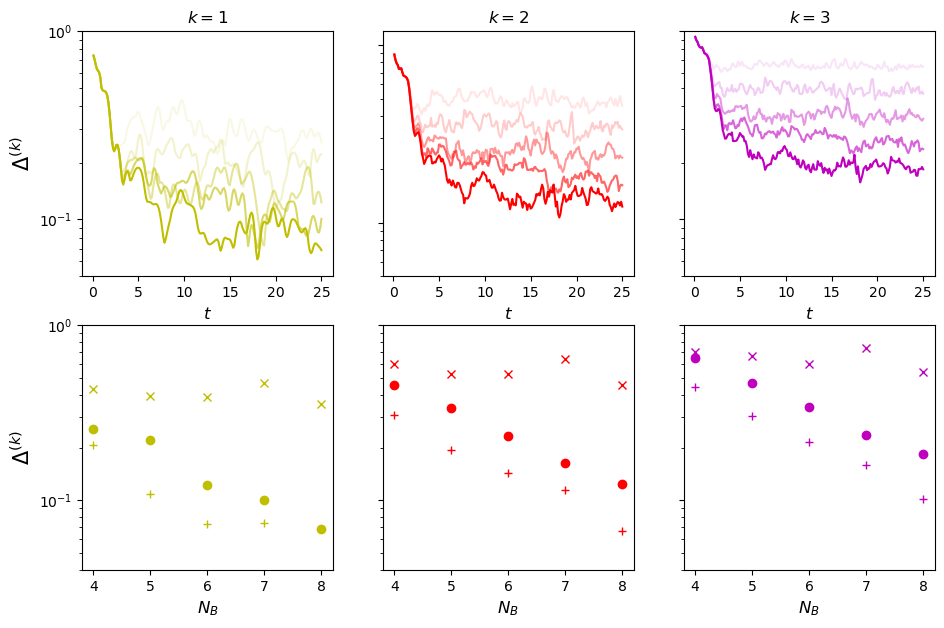

In [8]:
data = np.load('Trace_distances.npz')
times = data['times']
Ch_Dist = data['Ch_Dist']
Int_Dist = data['Int_Dist']

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(11,7))

axes[0,0].plot(times, Ch_Dist[0,0], color='y', alpha=0.1)
axes[0,0].plot(times, Ch_Dist[1,0], color='y', alpha=0.2)
axes[0,0].plot(times, Ch_Dist[2,0], color='y', alpha=0.4)
axes[0,0].plot(times, Ch_Dist[3,0], color='y', alpha=0.6)
axes[0,0].plot(times, Ch_Dist[4,0], color='y', alpha=1)
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(0.05,1)
axes[0,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[0,0].set_xlabel('$t$',size=12)
axes[0,0].set_title('$k = 1$')

axes[0,1].plot(times, Ch_Dist[0,1], color='r', alpha=0.1)
axes[0,1].plot(times, Ch_Dist[1,1], color='r', alpha=0.2)
axes[0,1].plot(times, Ch_Dist[2,1], color='r', alpha=0.4)
axes[0,1].plot(times, Ch_Dist[3,1], color='r', alpha=0.6)
axes[0,1].plot(times, Ch_Dist[4,1], color='r', alpha=1)
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(0.05,1.2)
axes[0,1].set_yticklabels('')
axes[0,1].set_xlabel('$t$',size=12)
axes[0,1].set_title('$k=2$')

axes[0,2].plot(times, Ch_Dist[0,2], color='m', alpha=0.1)
axes[0,2].plot(times, Ch_Dist[1,2], color='m', alpha=0.2)
axes[0,2].plot(times, Ch_Dist[2,2], color='m', alpha=0.4)
axes[0,2].plot(times, Ch_Dist[3,2], color='m', alpha=0.6)
axes[0,2].plot(times, Ch_Dist[4,2], color='m', alpha=1)
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(0.05,1)
axes[0,2].set_yticklabels('')
axes[0,2].set_xlabel('$t$',size=12)
axes[0,2].set_title('$k = 3$')

axes[1,0].plot(N_Bs, Ch_Dist[:,0,-1], 'yo')
axes[1,0].plot(N_Bs, Int_Dist[:,0,-1], 'yx')
axes[1,0].plot(N_Bs, Emp_Haar_Dist[:,0], 'y+')
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(0.04,1)
axes[1,0].set_ylabel('$\Delta^{(k)}$',size=15)
axes[1,0].set_xlabel('$N_B$',size=12)

axes[1,1].plot(N_Bs, Ch_Dist[:,1,-1], 'ro')
axes[1,1].plot(N_Bs, Int_Dist[:,1,-1], 'rx')
axes[1,1].plot(N_Bs, Emp_Haar_Dist[:,1], 'r+')
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(0.04,1)
axes[1,1].set_yticklabels('')
axes[1,1].set_xlabel('$N_B$',size=12)

axes[1,2].plot(N_Bs, Ch_Dist[:,2,-1], 'mo')
axes[1,2].plot(N_Bs, Int_Dist[:,2,-1], 'mx')
axes[1,2].plot(N_Bs, Emp_Haar_Dist[:,2], 'm+')
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(0.04,1)
axes[1,2].set_yticklabels('')
axes[1,2].set_xlabel('$N_B$',size=12)



## 2. Additional stuff: some checks, some variations

### 2.1. Compare $k=1$ to direct calculation of reduced density matrix

As a quick check I will compute the $k=1$ results using the partial trace, bypassing the projected ensemble part entirely. Will just compute is both ways and compute the trace distance between them, so expect zero or very small difference at all times, for any $N_B$. Will just use $N_B = 4$.

In [9]:
times = np.linspace(0.1,25,200)
distances = np.empty(np.size(times))

# Fixed variables
N_A = 2
N_B = 6
h_x = 0.8090
h_y = 0.9045
J = 1

d = 2**N_A

H = QIMF(N_A, N_B, h_x, h_y, J)
Psi0 = Psi_initial(N_A, N_B)


for j, t in enumerate(times):
    U = expm(-t * 1j * H)
    Psi = U @ Psi0  
    PrEns = Get_PrEns(Psi, N_A, N_B)
    rho_1_PrEns = rho_PrEns(PrEns, 1)
    rho_1_Trace = np.trace(np.outer(np.conjugate(Psi),Psi).reshape(2**N_A,2**N_B,2**N_A,2**N_B), axis1=1, axis2=3)

    dist_1 = np.linalg.norm(rho_1_PrEns - rho_1_Trace, 'nuc') / 2
    distances[j] = dist_1

print(np.max(distances))

1.0863991694616626e-16


Result: it is the same as expected. Trace distances between the density matrices calculated through the different routes are of order $10^{-16}$ or smaller.

### 2.2. Time-dependent Hamiltonian

Simplest case: changing between two different Hamiltonians, both of the QIMF type but with different coefficients.